# Traits Prototype

In [57]:
import logging
import yfinance as yf

from mplchart.chart import Chart

from mplchart.library import get_series, calc_ema
from mplchart.primitives import Candlesticks, OHLC, Volume

from dataclasses import dataclass

logging.basicConfig(level=logging.INFO)

In [58]:
ticker = "AAPL"
prices = yf.Ticker(ticker).history(period="5y")
prices

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-16 00:00:00-04:00,52.671289,53.251878,52.630165,53.196236,84632400,0.0,0.0
2019-09-17 00:00:00-04:00,53.210747,53.418791,53.007539,53.389759,73274800,0.0,0.0
2019-09-18 00:00:00-04:00,53.476849,53.909872,53.084954,53.890518,101360000,0.0,0.0
2019-09-19 00:00:00-04:00,53.706663,54.130007,53.309929,53.452660,88242400,0.0,0.0
2019-09-20 00:00:00-04:00,53.554273,53.839726,52.608400,52.671295,221652400,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-09 00:00:00-04:00,220.820007,221.270004,216.710007,220.910004,67180000,0.0,0.0
2024-09-10 00:00:00-04:00,218.919998,221.479996,216.729996,220.110001,51591000,0.0,0.0
2024-09-11 00:00:00-04:00,221.460007,223.089996,217.889999,222.660004,44587100,0.0,0.0


In [59]:

import inspect

from typing import Any
from dataclasses import dataclass, field

from mplchart.utils import series_xy, get_series
from mplchart.model import Indicator


@dataclass
class Line:
    name: str = field(init=False, default=None)
    item: str = None
    color: str = None
    label: bool = False

    def __set_name__(self, owner, name):
        self.name = name

    def plot_trait(self, data, chart, ax, parent=None):
        logging.info("plot_result %r", self)

        label = repr(parent) if self.label else None
        color = self.color

        xv, yv = series_xy(data)

        ax.plot(xv, yv, label=label, color=color)


class DEMA(Indicator):
    """Double Exponential Moving Average"""

    line = Line(color="red", label=True)

    same_scale = True
    # same_scale is an optional class attribute
    # to specify that the indicator can be drawn
    # on the same axes as the previous indicator

    def __init__(self, period: int = 20):
        self.period = period

    def __call__(self, prices):
        series = get_series(prices)
        ema1 = calc_ema(series, self.period)
        ema2 = calc_ema(ema1, self.period)
        return 2 * ema1 - ema2
    
    def plot_result(self, data, chart, ax=None):
        logging.info("plot_result %r", self)

        def is_trait(m):
            return hasattr(m, "plot_trait")

        members = inspect.getmembers(self, predicate=is_trait)
        print("members", members)

        for name, member in members:
            print("member", name)
            member.plot_trait(data, chart, ax, parent=self)


            

In [60]:
res = DEMA(20)(prices)
res.tail()

Date
2024-09-09 00:00:00-04:00    224.504827
2024-09-10 00:00:00-04:00    223.817881
2024-09-11 00:00:00-04:00    223.684504
2024-09-12 00:00:00-04:00    223.585986
2024-09-13 00:00:00-04:00    223.448957
Name: close, dtype: float64

INFO:root:plot_result DEMA(20)
INFO:root:plot_result Line(name='line', item=None, color='red', label=True)


members [('line', Line(name='line', item=None, color='red', label=True))]
member line


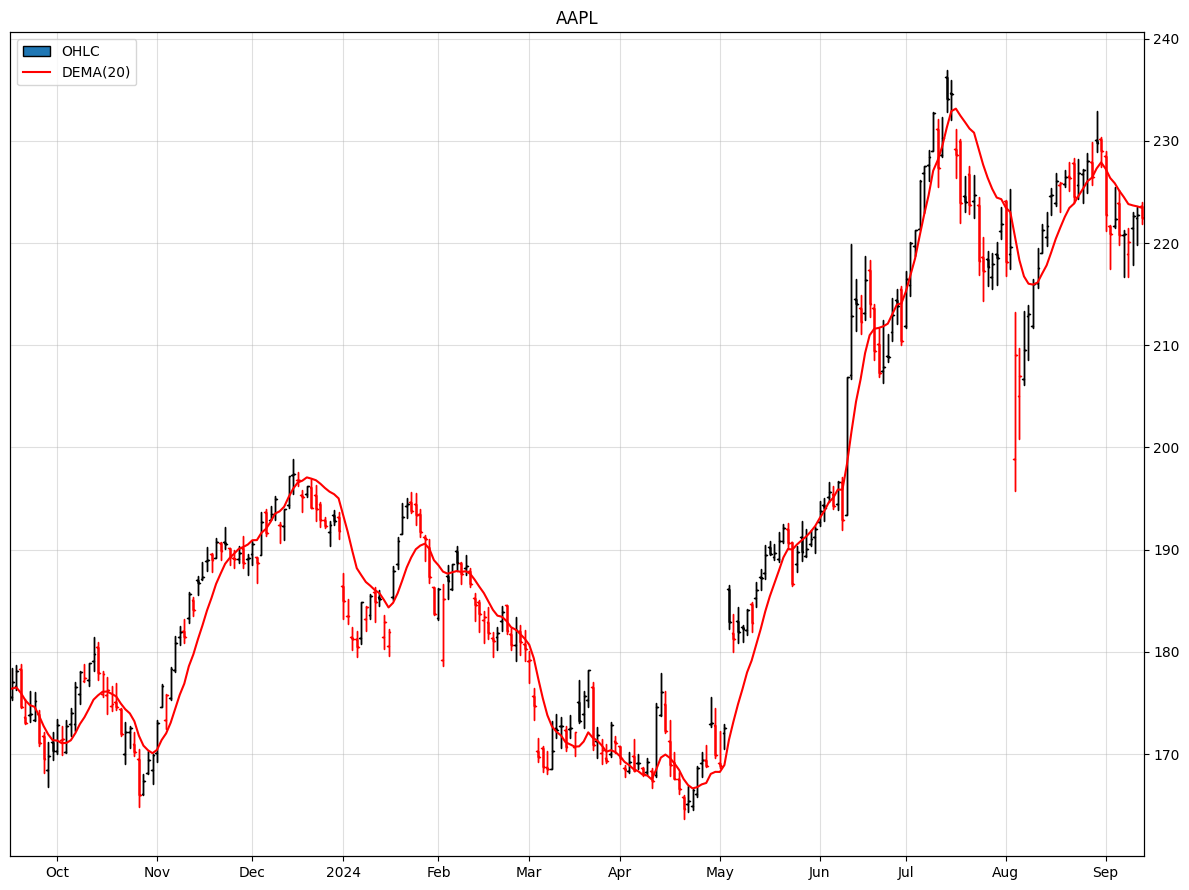

In [61]:
max_bars = 250

indicators = [
    OHLC(),
    DEMA(20),
]

chart = Chart(title=ticker, max_bars=max_bars)
chart.plot(prices, indicators)